# Projeto de Detecção de Doenças usando Deep Learning

## Importação das bibliotecas e base de dados

In [1]:
import os
import cv2 #OpenCV
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, AveragePooling2D, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
xray_directory = '/content/drive/MyDrive/Detecção de doenças com Deep Learning/Dataset'

In [4]:
# Quais são as pastas dentro do diretório 'Dataset'
# Cada classe de imagens precisa estar em uma pasta separada

os.listdir(xray_directory)

['.DS_Store', '2', '3', '1', '0']

In [5]:
image_generator = ImageDataGenerator(rescale=1./255)

In [6]:
train_generator = image_generator.flow_from_directory(batch_size = 40, directory=xray_directory,
                                                      shuffle = True, target_size=(256, 256),
                                                      class_mode = 'categorical', subset='training')

Found 532 images belonging to 4 classes.


In [ ]:
133 * 4

532

In [ ]:
532 / 40

13.3

In [7]:
train_images, train_labels = next(train_generator)

In [8]:
train_images.shape

(40, 256, 256, 3)

In [11]:
train_labels

array([[1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.]],

In [10]:
# Covid19 - 1 0 0 0
# Normal  - 0 1 0 0
# Viral   - 0 0 1 0
# Bacterial - 0 0 0 1
labels_names = {0: 'Covid-19', 1: 'Normal', 2: 'Pneunomia viral', 3: 'Pneunomia bacterial'}

## Visualização dos dados

In [12]:
np.arange(0, 36)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35])

In [18]:
# Qual o índice com o maior valor no train_labels índice zero
np.argmax(train_labels[0])

0

In [ ]:
labels_names[1]

'Normal'

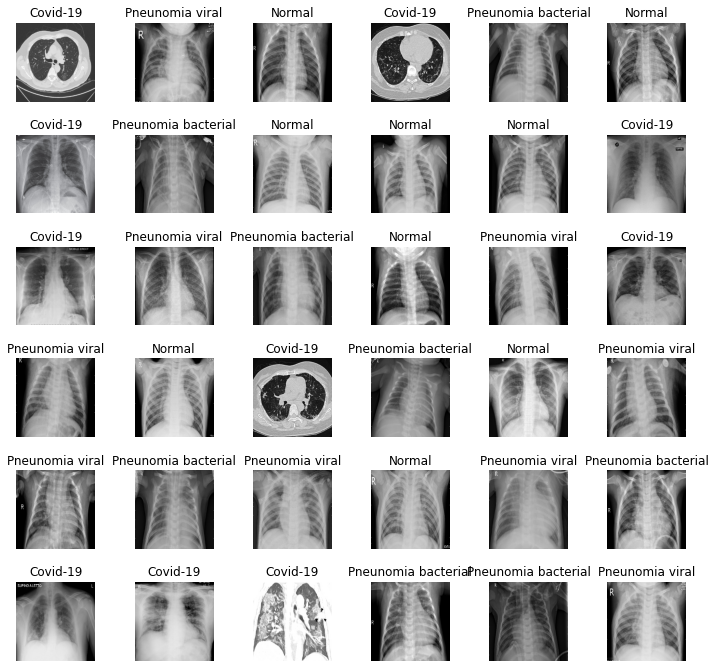

In [17]:
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(12, 12))
axes = axes.ravel()
for i in np.arange(0, 36):
  axes[i].imshow(train_images[i])
  axes[i].set_title(labels_names[np.argmax(train_labels[i])])     # Define o 'title' de cada imagem (grafíco/subplot)
  axes[i].axis('off')   # Para retirar o x e y
plt.subplots_adjust(wspace=0.5)     # Para aumentar a distância entre as imagens (gráficos/subplots)

## Carregamento da rede neural com pesos pré-treinados

### [Informação sobre redes convolucionais](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwien_Ky-oj7AhUbGrkGHZ4lATUQFnoECBAQAw&url=https%3A%2F%2Fwww.digitalhouse.com%2Fbr%2Fblog%2Frede-neural-convolucional%2F%23%3A~%3Atext%3DUma%2520rede%2520neural%2520convolucional%2520%25C3%25A9%2520utilizada%2520para%2520se%2520trabalhar%2520com%2Creconhecimento%2520e%2520categoriza%25C3%25A7%25C3%25A3o%252C%2520entre%2520outros.&usg=AOvVaw3oCat8W4KIaVEMQEX_ncCR)

[Informação sobre ResNet](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwiko7_1gYn7AhW-HrkGHW-8BSsQFnoECBMQAQ&url=https%3A%2F%2Fen.wikipedia.org%2Fwiki%2FResidual_neural_network&usg=AOvVaw2jtuGM7RGvm0GLmLABEGCM) 

[Informação sobre ImageNet](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwjLwPW_gon7AhXCIbkGHdtUCxIQFnoECAoQAQ&url=https%3A%2F%2Fwww.image-net.org%2F&usg=AOvVaw07SoUbpxRQk8ZNEiJoLqt5)

In [19]:
base_model = ResNet50(weights='imagenet', include_top=False,
                      input_tensor = Input(shape=(256,256,3)))

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [20]:
len(base_model.layers)

175

In [21]:
for layer in base_model.layers[:-10]:
  layers.trainable = False

## Construção e treinamento do modelo de deep learning

In [28]:
head_model = base_model.output
head_model = AveragePooling2D()(head_model)
head_model = Flatten()(head_model)
head_model = Dense(256, activation = 'relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(128, activation = 'relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(4, activation = 'softmax')(head_model)

In [29]:
model = Model(inputs = base_model.input, outputs = head_model)

In [30]:
model.compile(loss = 'categorical_crossentropy', optimizer=optimizers.RMSprop(lr = 1e-4, decay=1e-6),
              metrics = ['accuracy'])

In [31]:
checkpointer = ModelCheckpoint(filepath='weights.hdf5')

In [32]:
train_generator = image_generator.flow_from_directory(batch_size = 4, directory=xray_directory,
                                                      shuffle = True, target_size=(256, 256),
                                                      class_mode = 'categorical', subset='training')

Found 532 images belonging to 4 classes.


In [35]:
history = model.fit_generator(train_generator, epochs = 12, 
                              callbacks=[checkpointer])

Epoch 1/12


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


133/133 [==============================] - 476s 4s/step - loss: 0.4713 - accuracy: 0.8853
Epoch 2/12
133/133 [==============================] - 477s 4s/step - loss: 0.3072 - accuracy: 0.9323
Epoch 3/12
133/133 [==============================] - 468s 4s/step - loss: 0.2587 - accuracy: 0.9492
Epoch 4/12
133/133 [==============================] - 466s 4s/step - loss: 0.2576 - accuracy: 0.9492
Epoch 5/12
133/133 [==============================] - 469s 4s/step - loss: 0.2405 - accuracy: 0.9662
Epoch 6/12
133/133 [==============================] - 474s 4s/step - loss: 0.1445 - accuracy: 0.9756
Epoch 7/12
133/133 [==============================] - 471s 4s/step - loss: 0.0367 - accuracy: 0.9887
Epoch 8/12
133/133 [==============================] - 473s 4s/step - loss: 0.1327 - accuracy: 0.9868
Epoch 9/12
133/133 [==============================] - 466s 4s/step - loss: 0.0298 - accuracy: 0.9944
Epoch 10/12
133/133 [==============================] - 464s 3s/step - loss: 0.0988 - accuracy: 0.9850


## Avaliação da rede neural

In [36]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

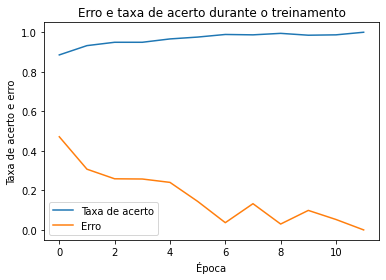

In [37]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Erro e taxa de acerto durante o treinamento')
plt.xlabel('Época')
plt.ylabel('Taxa de acerto e erro')
plt.legend(['Taxa de acerto', 'Erro']);

In [38]:
test_directory = '/content/drive/MyDrive/Detecção de doenças com Deep Learning/Test'

In [39]:
os.listdir(test_directory)

['3', '0', '2', '1']

In [40]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_directory(batch_size = 40, directory = test_directory,
                                              shuffle = True, target_size = (256, 256),
                                              class_mode = 'categorical')

Found 40 images belonging to 4 classes.


In [41]:
evaluate = model.evaluate_generator(test_generator)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


In [42]:
evaluate

[2.6003053188323975, 0.675000011920929]

In [43]:
len(os.listdir(test_directory))

4

In [44]:
prediction = []
original = []
image = []

for i in range(len(os.listdir(test_directory))):
  for item in os.listdir(os.path.join(test_directory, str(i))):
    #print(os.listdir(os.path.join(test_directory, str(i))))
    img = cv2.imread(os.path.join(test_directory, str(i), item))
    img = cv2.resize(img, (256, 256))
    image.append(img)
    img = img / 255
    img = img.reshape(-1, 256, 256, 3)
    predict = model.predict(img)
    predict = np.argmax(predict)
    prediction.append(predict)
    original.append(i)

1/1 [==============================] - 0s 241ms/step


In [45]:
print(prediction)

[0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 2, 2, 3, 2, 3, 2, 1, 3, 2, 2, 2, 2, 2, 3]


In [46]:
print(original)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [47]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [48]:
accuracy_score(original, prediction)

0.65

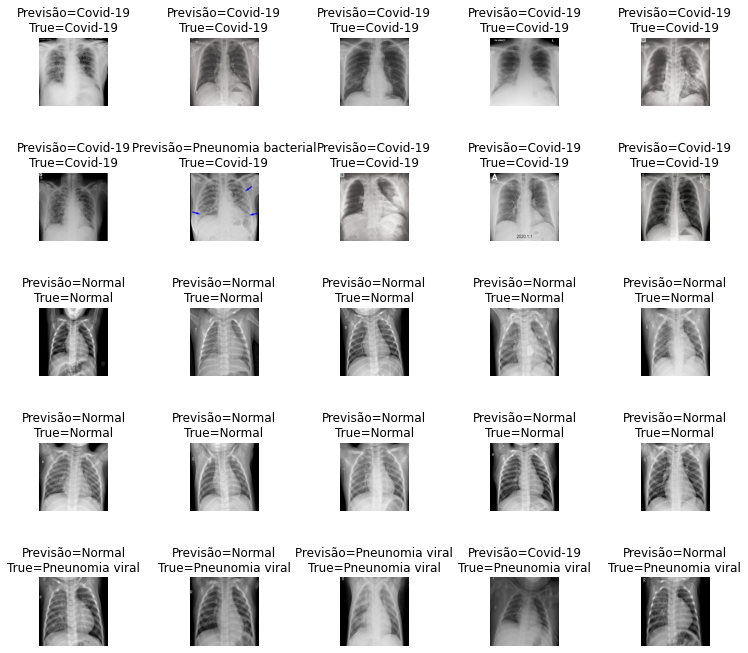

In [49]:
fig, axes = plt.subplots(5, 5, figsize=(12,12))
axes = axes.ravel()
for i in np.arange(0, 25):
  axes[i].imshow(image[i])
  axes[i].set_title('Previsão={}\nTrue={}'.format(str(labels_names[prediction[i]]), str(labels_names[original[i]])))
  axes[i].axis('off')
plt.subplots_adjust(wspace = 1.2)

In [50]:
labels_names

{0: 'Covid-19', 1: 'Normal', 2: 'Pneunomia viral', 3: 'Pneunomia bacterial'}

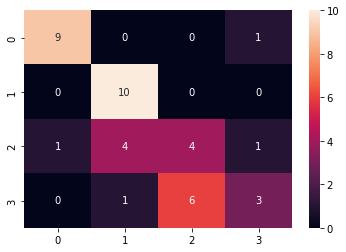

In [51]:
cm = confusion_matrix(original, prediction)
sns.heatmap(cm, annot=True);

In [52]:
print(classification_report(original, prediction))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.67      1.00      0.80        10
           2       0.40      0.40      0.40        10
           3       0.60      0.30      0.40        10

    accuracy                           0.65        40
   macro avg       0.64      0.65      0.62        40
weighted avg       0.64      0.65      0.62        40



## Classificação de somente uma imagem

In [53]:
from keras.models import load_model
model_loaded = load_model('/content/weights.hdf5')

In [54]:
model_loaded.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [55]:
4 * 4 * 2048

32768

In [58]:
img = cv2.imread('/content/drive/MyDrive/Detecção de doenças com Deep Learning/Test/0/radiol.2020200490.fig3.jpeg')

In [59]:
img, img.shape

(array([[[192, 192, 192],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [134, 134, 134]],
 
        [[192, 192, 192],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [134, 134, 134]],
 
        [[192, 192, 192],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [134, 134, 134]],
 
        ...,
 
        [[196, 196, 196],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  3,   3,   3],
         [134, 134, 134]],
 
        [[187, 187, 187],
         [  5,   5,   5],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  7,   7,   7],
         [129, 129, 129]],
 
        [[214, 214, 214],
         [ 80,  80,  80],
         [ 87,  87,  87],
         ...,
         [ 80,  80,  80],
  

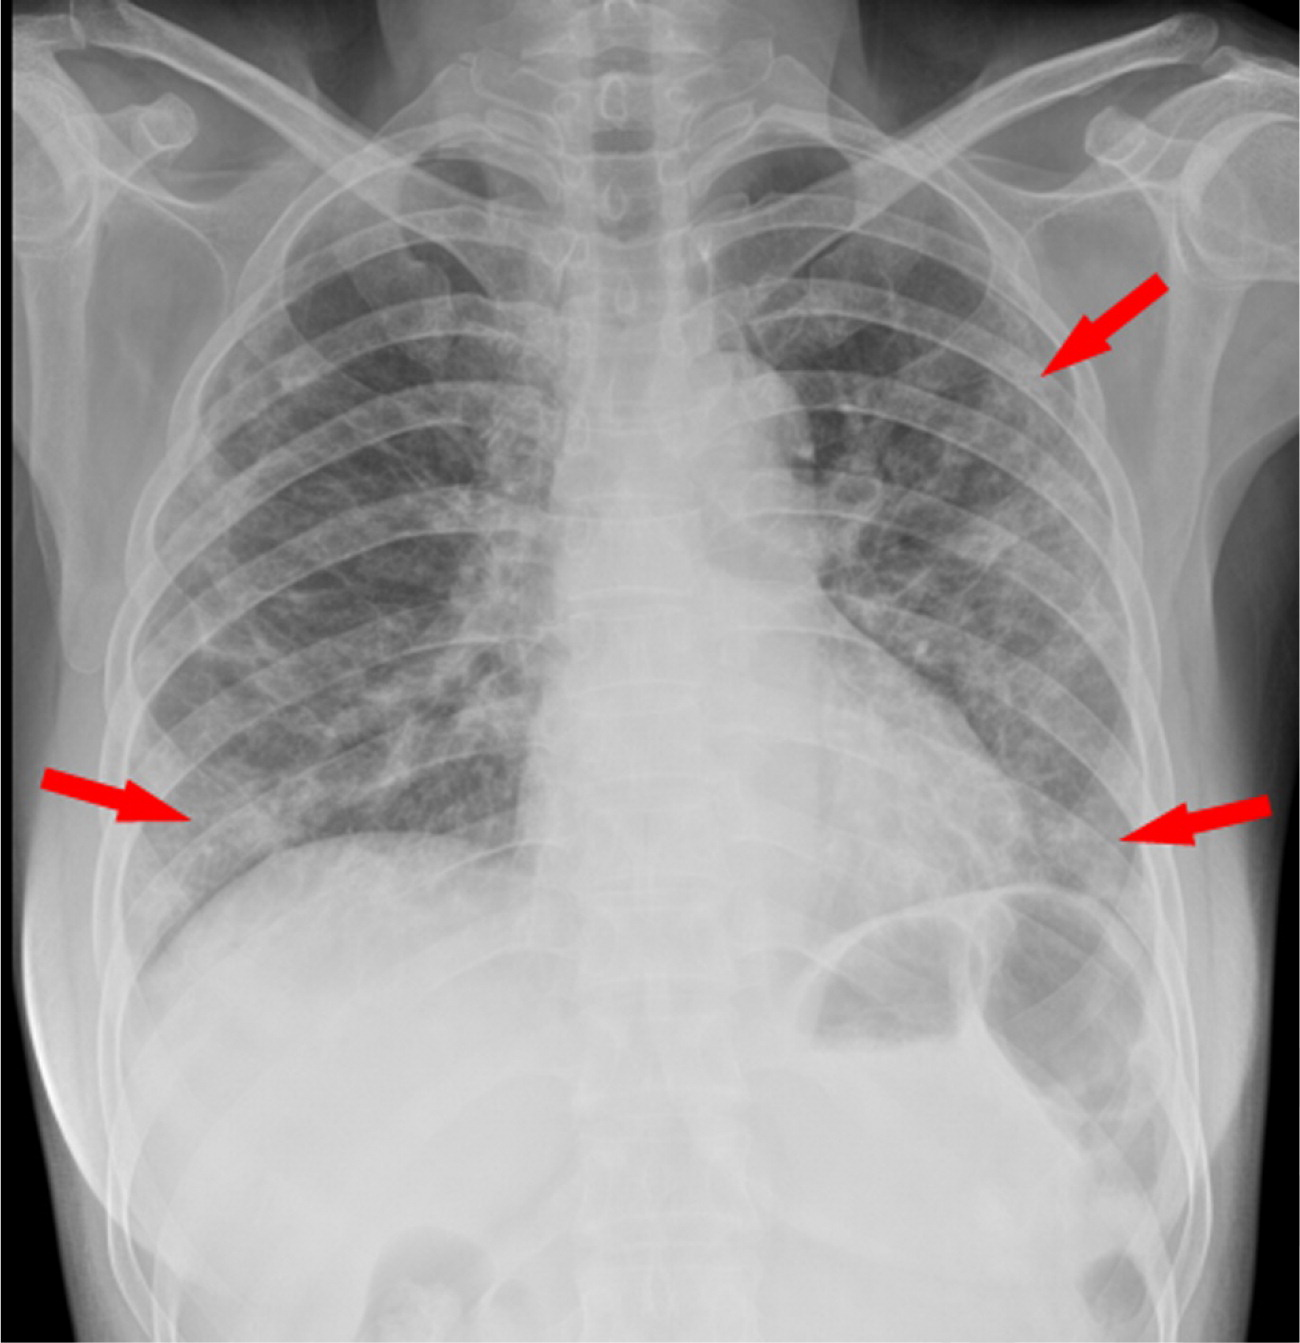

In [60]:
from google.colab.patches import cv2_imshow
cv2_imshow(img)

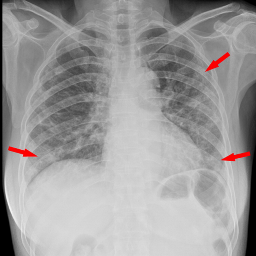

In [61]:
img = cv2.resize(img, (256, 256))
cv2_imshow(img)

In [62]:
img = img / 255
img

array([[[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.10980392, 0.10980392, 0.10980392],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.12941176, 0.12941176, 0.12941176],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.16470588, 0.16470588, 0.16470588],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       ...,

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0

In [63]:
img.shape

(256, 256, 3)

In [64]:
img = img.reshape(-1, 256, 256, 3)
img.shape

(1, 256, 256, 3)

In [65]:
predict = model_loaded(img)
predict

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0.47508016, 0.        , 0.        , 0.5249198 ]], dtype=float32)>

In [66]:
predict2 = np.argmax(predict)
predict2

3

In [67]:
labels_names[predict2], predict[0][predict2]

('Pneunomia bacterial', <tf.Tensor: shape=(), dtype=float32, numpy=0.5249198>)